# Tuning a neural network hyperparameters through a genetic evolution

The purpose of this notebook is to make a **simple proof-of-concept** of the ability for a genetic algorithm to automatically **tune the hyperparameters** of a neural network though evolutions. The goal will be to obtain **the best neural network model** that approximates the sin() function.

For a more acomplished analysis of the performance of this genetic algorithm, please visit the "

**Author**: François Andrieux

- https://linkedin.com/in/francois-andrieux
- https://twitter.com/Spriteware
- https://github.com/Spriteware

You can get detailed explanations and other experiments on [franpapers.com](https://franpapers.com).    
   

**Summary**:
1.  The goal: approximate the sin() function
2.  Models
3.  Evolution
4.  Start the evolution!
    1.  Configure the fitness function
    2.  Create the initial population
    3.  Launch the evolution:
5.  Display the best player in the game
6.  Analyze how which parameter influences


In [9]:
import genev # import genetic evolution core
from genev import Individual, Evolution

import time
import math
import sys
import copy
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn import utils

sns.set()
%matplotlib inline  
# %config InlineBackend.figure_format = "retina"

## The goal: approximate the sin() function

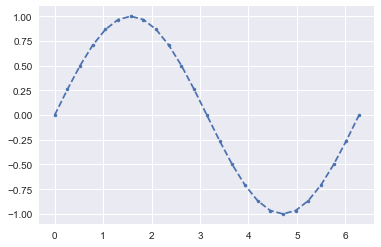

In [10]:
X = np.linspace(0.0, 6.28318530718, num=25).reshape(25, 1)
Y = np.asarray([math.sin(x) for x in X]).reshape(25, 1)
plt.plot(X, Y, ".--");

## Models

In [11]:
import os
import tensorflow as tf

#os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [12]:
class Model():

    def __init__(self, learning_rate, momentum=0.9, lr_decay=0.0, hidden_layers=1, hidden_size=1, activation_id=0):
        
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.lr_decay = lr_decay
        self.hidden_layers = hidden_layers
        self.hidden_size = hidden_size
        self.activation_id = activation_id
        
        self.train_losses = []
        self.test_losses = []
        self.times = []
        self.training_time = None
        self.aborted = False
        
        # Initialize session
        self.build()
        
    def build(self):
        
        tf.reset_default_graph()
        self.graph = tf.Graph()

        with self.graph.as_default():
            with tf.variable_scope("Core_layers"):

                activations = [tf.nn.sigmoid, tf.nn.tanh]
                activation = activations[self.activation_id]
                
                x = tf.placeholder(tf.float32, shape=(None, 1))
                y = tf.placeholder(tf.float32, shape=(None, 1))
                layers = [tf.layers.dense(inputs=x, units=1, activation=None)]

                for i in range(self.hidden_layers):
                    layers.append(tf.layers.dense(inputs=layers[-1], units=self.hidden_size, activation=activation))

                output = tf.layers.dense(inputs=layers[-1], units=1, activation=None)

                squared_deltas = tf.square(output - y)
                loss = tf.get_variable("loss", [1])
                loss = tf.reduce_sum(squared_deltas)

                optimizer = tf.train.RMSPropOptimizer(self.learning_rate, momentum=self.momentum, decay=self.lr_decay)
                train = optimizer.minimize(loss)

                self.x = x
                self.y = y
                self.loss = loss
                self.train = train
                self.output = output
                self.sess = tf.Session()

                assert loss.graph is self.graph
            
    def fit(self, X, Y, epochs):

        with self.graph.as_default():
            
            x, y = self.x, self.y
            loss, train = self.loss, self.train
            sess = self.sess
            
            sess.run(tf.global_variables_initializer())
            self.train_losses = []
            self.test_losses = []
            self.times = []

            for i in range(epochs):
    
                start = time.time()
                if i % 10 == 0:
                    loss_t = sess.run([loss], {x: X, y: Y})

                    if not np.isfinite(loss_t[0]):
                        self.aborted = True
                        break
                    self.test_losses.append(loss_t[0])
                else:
                    _, loss_t = sess.run([train, loss], {x: X, y: Y})

                    if not np.isfinite(loss_t):
                        self.aborted = True
                        break
                    self.train_losses.append(loss_t)
                    
                self.times.append(time.time() - start)

            self.train_losses = np.asarray(self.train_losses)
            self.test_losses = np.asarray(self.test_losses)
            self.training_time = np.sum(self.times)
            
            return self.train_losses, self.test_losses, self.times
    
    def predict(self, X):
        
        with self.graph.as_default():
            output = self.sess.run([self.output], {self.x: X})
            output = np.asarray(output)
            
        return output.reshape(output.shape[1], output.shape[2])
    
    def free(self):
        with self.graph.as_default():
            self.sess.close()
            
    def display(self, log_scale=False):
        train, test = np.asarray(self.train_losses), np.asarray(self.test_losses)
        # Todo : display like my other notebooks
        
        if log_scale is True:
            train, test = np.log(train), np.log(test)
            
        plt.plot(train, label="Train losses")
        plt.plot(np.linspace(0, train.shape[0], test.shape[0]), test, label="Test losses");
        plt.legend()
        plt.show()
        
    def __delete__(self):
        self.free()

In [13]:
m1 = Model(learning_rate=0.005, momentum=0.85, lr_decay=0.0693, hidden_layers=5, hidden_size=13)
m2 = Model(learning_rate=0.005, momentum=0.85, lr_decay=0.0693, hidden_layers=5, hidden_size=13)

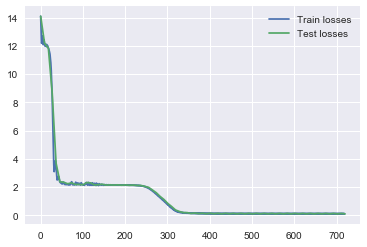

training_time 0.738776683807373


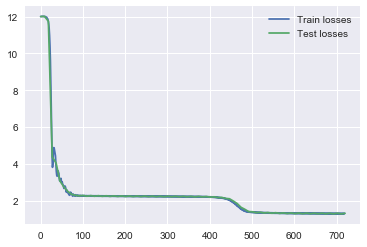

training_time 0.5317940711975098


In [14]:
ltrain, ltest, t = m1.fit(X, Y, epochs=800)
m1.display()
print("training_time", m1.training_time)

ltrain, ltest, t = m2.fit(X, Y, epochs=800)
m2.display()
print("training_time", m2.training_time)

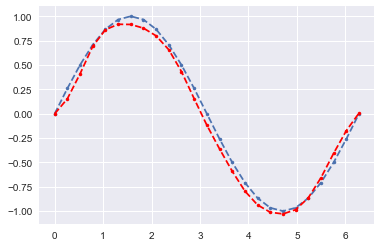

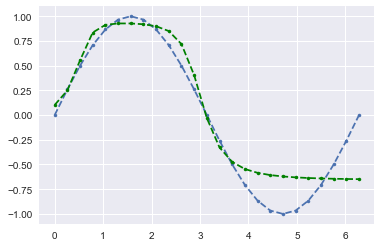

In [22]:
sample = m1.predict(X)
plt.plot(X, Y, ".--");
plt.plot(X, sample, ".--r");
plt.show()

sample = m2.predict(X)
plt.plot(X, Y, ".--");
plt.plot(X, sample, ".--g");
plt.show()

Important: do not forget to free the session, if not it will be huge in a while

In [23]:
del m1
del m2

## Evolution

In [24]:
skeleton = {
    "learning_rate": (float, lambda: 10 ** np.random.uniform(-4, 0)),
    "momentum": (float, lambda: np.random.uniform(0, 1)),
    "lr_decay": (float, lambda: 10 ** np.random.uniform(-6, 0)),
    "hidden_layers": (int, lambda: np.round(np.random.uniform(0, 5))),
    "hidden_size": (int, lambda: np.round(np.random.uniform(0, 25)))
}

## Start the evolution!
### Configure the fitness function
The fitness function is the most important here, because it is what determines the score of an individual and a generation. The more precise it is, the more you have control over how your individuals are chosen and the speed of the convergence towards a good generation, however it must stay suficiently free to reveal the real power of random solution.  
Here, the parameters are the following:
* The last **train loss**
* The last **test loss**
* The **time** for an epoch

In [25]:
def calc_fitness(model):
    
    epochs = 1000
    train_losses, test_losses, times = model.fit(X, Y, epochs=epochs)    

    train = sys.maxsize if len(train_losses) == 0 else train_losses[-1] 
    test = sys.maxsize if len(test_losses) == 0 else test_losses[-1]    
    
    return train + test + np.mean(times) * 1000

### Create the initial population

In [26]:
ev = Evolution(10, structure=Model, dna_skeleton=skeleton)
ev.model(Model, skeleton, calc_fitness)
ev.create()
ev.evaluate(display=True);

evaluation: 100.00%	(10 over 10)


### Launch the evolution:

In [27]:
ev.evolve(10);
ev.evaluate(display=True)

0 -------------------------- 
evaluation: 100.00%	(10 over 10)
mutated: 6/7, 85.71% 
1 -------------------------- 
evaluation: 100.00%	(10 over 10)
mutated: 6/7, 85.71% 
2 -------------------------- 
evaluation: 100.00%	(10 over 10)
mutated: 6/7, 85.71% 
3 -------------------------- 
evaluation: 100.00%	(10 over 10)
mutated: 6/7, 85.71% 
4 -------------------------- 
evaluation: 100.00%	(10 over 10)
mutated: 6/7, 85.71% 
5 -------------------------- 
evaluation: 100.00%	(10 over 10)
mutated: 6/7, 85.71% 
6 -------------------------- 
evaluation: 100.00%	(10 over 10)
mutated: 6/7, 85.71% 
7 -------------------------- 
evaluation: 100.00%	(10 over 10)
mutated: 6/7, 85.71% 
8 -------------------------- 
evaluation: 100.00%	(10 over 10)
mutated: 6/7, 85.71% 
9 -------------------------- 
evaluation: 100.00%	(10 over 10)
mutated: 6/7, 85.71% 
evaluation: 100.00%	(10 over 10)


## Display the best player in the game 

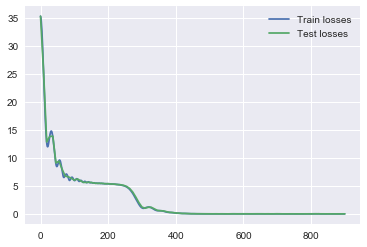

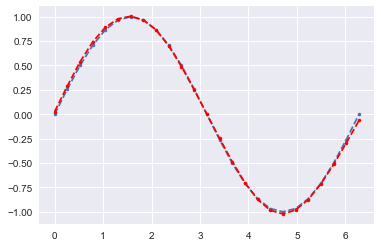

[#48 / gen 8]	score is 0.696196474134922


In [28]:
elite = ev.elite
elite.obj.display()
plt.show()

plt.plot(X, Y, ".--");
sample = elite.obj.predict(X)
plt.plot(X, sample, ".--r");
plt.show()
print(elite)

## Analyze how which parameter influences

In [29]:
list(ev.skeleton_stats.keys())

['learning_rate', 'momentum', 'lr_decay', 'hidden_layers', 'hidden_size']

The visual analysis will help us to understand which values were generated and how they are collerated to the success of the fitness score.

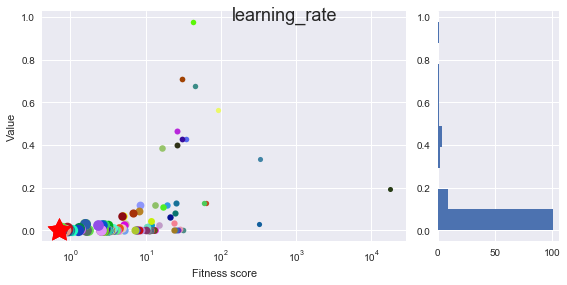

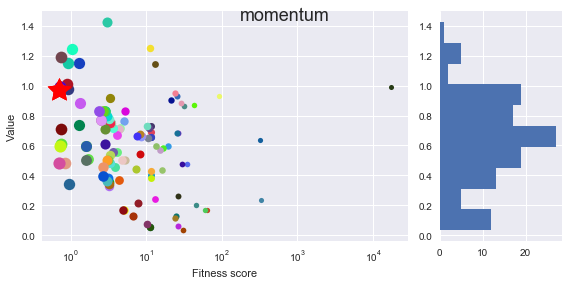

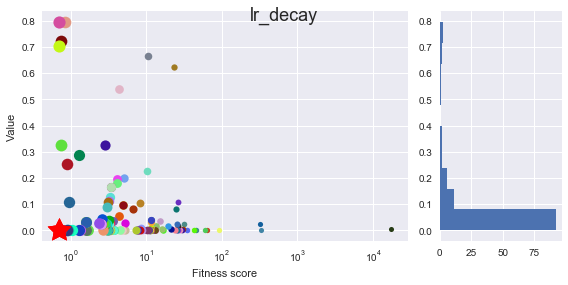

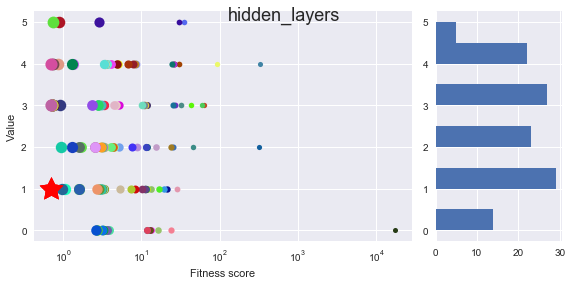

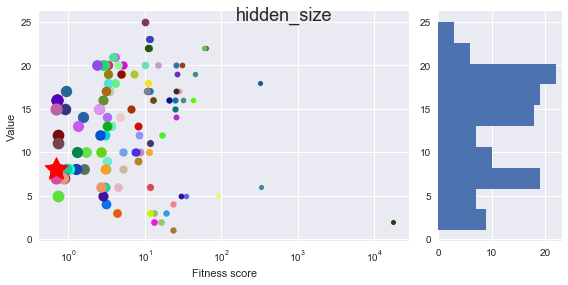

In [30]:
ev.visual_analysis()

## Export the notebook

In [36]:
!jupyter nbconvert --to markdown sine_genetic_approximation.ipynb
!mv sine_genetic_approximation.md README.md

[NbConvertApp] Converting notebook sine_genetic_approximation.ipynb to markdown
[NbConvertApp] Support files will be in sine_genetic_approximation_files\
[NbConvertApp] Making directory sine_genetic_approximation_files
[NbConvertApp] Making directory sine_genetic_approximation_files
[NbConvertApp] Making directory sine_genetic_approximation_files
[NbConvertApp] Making directory sine_genetic_approximation_files
[NbConvertApp] Making directory sine_genetic_approximation_files
[NbConvertApp] Making directory sine_genetic_approximation_files
[NbConvertApp] Making directory sine_genetic_approximation_files
[NbConvertApp] Making directory sine_genetic_approximation_files
[NbConvertApp] Making directory sine_genetic_approximation_files
[NbConvertApp] Making directory sine_genetic_approximation_files
[NbConvertApp] Making directory sine_genetic_approximation_files
[NbConvertApp] Making directory sine_genetic_approximation_files
[NbConvertApp] Writing 11913 bytes to sine_genetic_approximation.m